# **Fine-Tuning MobileNet**

## **Part 1: Basic Transfer Learning Implementation**

In this part, we will build a transfer learning pipeline using MobileNet as the base model, pre-trained on ImageNet, and adapt it for the TF Flowers dataset.

### **Load and prepare the TF Flowers dataset**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
def load_and_prepare_tf_flowers_numpy(img_size=(224, 224)):
    splits = ["train[:10%]", "train[10%:25%]", "train[25%:]"]
    (test_set_raw, valid_set_raw, train_set_raw), info = tfds.load(
        "tf_flowers", split=splits, as_supervised=True, with_info=True
    )

    def dataset_to_numpy(dataset, img_size):
        images, labels = [], []
        for img, label in dataset:
            img = img.numpy()
            img = np.array(Image.fromarray(img).resize(img_size))
            images.append(img)
            labels.append(label.numpy())
        return np.array(images), np.array(labels)

    train_images, train_labels = dataset_to_numpy(train_set_raw, img_size)
    valid_images, valid_labels = dataset_to_numpy(valid_set_raw, img_size)
    test_images, test_labels = dataset_to_numpy(test_set_raw, img_size)

    train_images = preprocess_input(train_images)
    valid_images = preprocess_input(valid_images)
    test_images = preprocess_input(test_images)

    class_names = info.features["label"].names
    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels), class_names

### **Implement a transfer learning workflow for MobileNet**
We’ll load the pretrained MobileNet, freeze its layers, add a new classification head, and train it only on the new layers.

In [ ]:
def build_transfer_model(input_shape, n_classes):
    # Load the pre-trained MobileNet model with ImageNet weights
    base_model = tf.keras.applications.MobileNet(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    # Freeze the base model
    base_model.trainable = False
    # Add classification layers and build the final model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"Total layers in model: {len(model.layers)}")
    print(f"Base model trainable: {base_model.trainable}")
    print(f"Trainable weights: {len(model.trainable_weights)}")
    print(f"Non-trainable weights: {len(model.non_trainable_weights)}")

    return model

**Train and evaluate the model**

In [ ]:
# Load dataset
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels), class_names = load_and_prepare_tf_flowers_numpy()

# Build model
model = build_transfer_model(input_shape=(224, 224, 3), n_classes= len(class_names))

# Train
history = model.fit(train_images, train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=5,
                    batch_size=32)

Total layers in model: 5
Base model trainable: False
Trainable weights: 2
Non-trainable weights: 135
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.4959 - loss: 1.3036 - val_accuracy: 0.8348 - val_loss: 0.4718
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8426 - loss: 0.4391 - val_accuracy: 0.8621 - val_loss: 0.3820
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8811 - loss: 0.3354 - val_accuracy: 0.8893 - val_loss: 0.3432
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9064 - loss: 0.2754 - val_accuracy: 0.8639 - val_loss: 0.3600
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9128 - loss: 0.2562 - val_accuracy: 0.8730 - val_loss: 0.3241


In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_images, test_labels, class_names):

    print("\n--- Evaluating model on test set ---")

    loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test accuracy: {accuracy:.2%}")

    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(8, 8))
    for i in range(min(9, len(test_images))):
        plt.subplot(3, 3, i + 1)

        img = test_images[i]
        if img.dtype != "uint8":
            img = img * 0.5 + 0.5
            img = (img * 255).astype("uint8")

        plt.imshow(img)

        correct = test_labels[i] == pred_classes[i]
        color = "green" if correct else "red"

        plt.title(f"Actual: {class_names[test_labels[i]]}\nPredicted: {class_names[pred_classes[i]]}",
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return loss, accuracy

In [ ]:
acc_Base = evaluate_model1(model, test_images, test_labels)
print(f"Base Model Test Accuracy: {acc_Base:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8757 - loss: 0.3268
Test Accuracy: 0.9046
Base Model Test Accuracy: 0.9046



--- Evaluating model on test set ---
Test accuracy: 90.46%
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


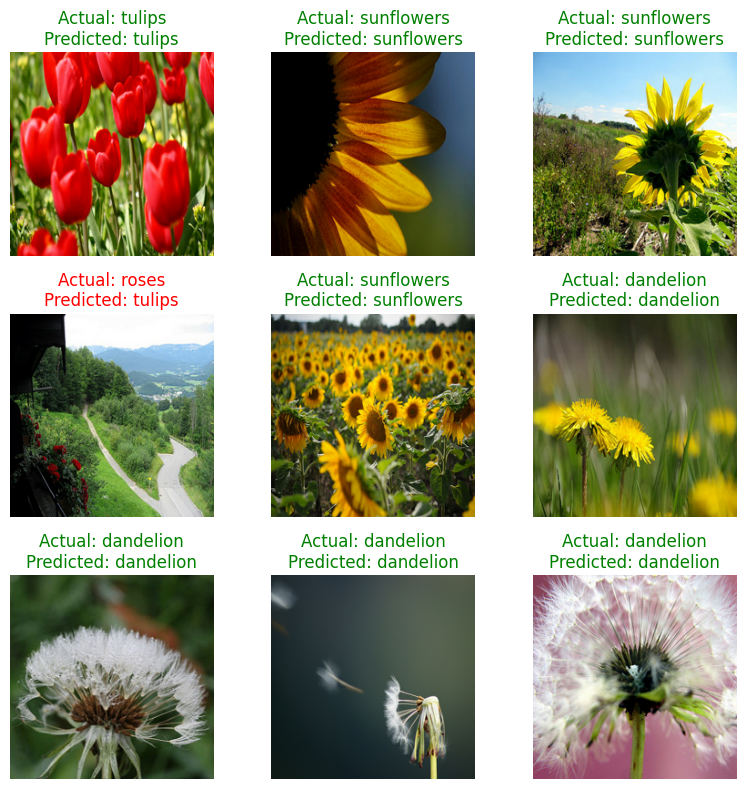

(0.2850187420845032, 0.9046321511268616)

In [ ]:
evaluate_model(model, test_images, test_labels, class_names)

In [ ]:
timeBase = measure_inference_time(model, test_images[:100])
print(f"Base Model Inference Time: {timeBase:.2f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step
Inference Time: 5.33 seconds for 100 images.
Base Model Inference Time: 5.33 seconds


In [ ]:
print("Trainable Parameters after Base Model:", count_trainable_params(model))

Trainable Parameters after Base Model: 5125


## **Part 2: Layer Unfreezing Strategies**
This section explores how different unfreezing strategies affect MobileNet’s performance. We define two strategies:

**Strategy A**: Unfreeze a specific number of layers from the end.

**Strategy B**: Unfreeze complete architectural blocks.

### **Strategy A: Unfreeze Last N Layers**
**Identify and Unfreeze Last N Layers**

In [ ]:
def unfreeze_last_n_layers(model, n):
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers[:-n]:
        layer.trainable = False
    print(f"Unfroze last {n} layers out of {len(base_model.layers)} total layers.")

**Retrain the Model with Partial Fine-Tuning**

In [ ]:
def fine_tune_model(model, train_images, train_labels, valid_images, valid_labels, epochs=5):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_images, train_labels,
                        validation_data=(valid_images, valid_labels),
                        epochs=epochs,
                        batch_size=32)
    return history

**Note:** Since fine-tuning modifies the model weights, we should create separate copies of the base model before applying each strategy — otherwise, both strategies would interfere with each other and lead to inaccurate comparisons

**Create a Base (Frozen) Model Once**

In [ ]:
input_shape = (224, 224, 3)
num_classes = len(class_names)

# Original frozen base
base_model_A_30 = build_transfer_model(input_shape, num_classes)
base_model_A_50 = build_transfer_model(input_shape, num_classes)
base_model_B = build_transfer_model(input_shape, num_classes)

Total layers in model: 5
Base model trainable: False
Trainable weights: 2
Non-trainable weights: 135
Total layers in model: 5
Base model trainable: False
Trainable weights: 2
Non-trainable weights: 135
Total layers in model: 5
Base model trainable: False
Trainable weights: 2
Non-trainable weights: 135


**Unfreeze last 30 layers**

In [ ]:
unfreeze_last_n_layers(base_model_A_30, 30)
history_A_30 = fine_tune_model(base_model_A_30, train_images, train_labels, valid_images, valid_labels)

Unfroze last 30 layers out of 86 total layers.
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.2943 - loss: 1.8907 - val_accuracy: 0.4991 - val_loss: 1.2446
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.6492 - loss: 0.9244 - val_accuracy: 0.7477 - val_loss: 0.7417
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.7781 - loss: 0.6432 - val_accuracy: 0.7967 - val_loss: 0.5616
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8317 - loss: 0.5043 - val_accuracy: 0.8312 - val_loss: 0.4843
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.8525 - loss: 0.4385 - val_accuracy: 0.8421 - val_loss: 0.4311


**Unfreeze last 50 layers**

In [ ]:
unfreeze_last_n_layers(base_model_A_50, 50)
history_A_50 = fine_tune_model(base_model_A_50, train_images, train_labels, valid_images, valid_labels)

Unfroze last 50 layers out of 86 total layers.
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.3756 - loss: 1.6422 - val_accuracy: 0.5354 - val_loss: 1.2538
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.6952 - loss: 0.8133 - val_accuracy: 0.7096 - val_loss: 0.7536
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8042 - loss: 0.5751 - val_accuracy: 0.7895 - val_loss: 0.5446
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.8394 - loss: 0.4415 - val_accuracy: 0.8276 - val_loss: 0.4624
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.8708 - loss: 0.3899 - val_accuracy: 0.8494 - val_loss: 0.4154


### **Strategy B: Unfreeze Full Blocks**

MobileNet is organized into depthwise separable convolution blocks. Here we selectively unfreeze full blocks.

**Identify Block Boundaries in MobileNet**

In [ ]:
def unfreeze_blocks_by_name(model, block_names):
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers:
        if any(block_name in layer.name for block_name in block_names):
            layer.trainable = True
        else:
            layer.trainable = False
    print(f"Unfroze blocks: {block_names}")

**Unfreeze final blocks**

In [ ]:
block_names = ['block_10', 'block_11', 'block_12', 'block_13']
unfreeze_blocks_by_name(base_model_B, block_names)
history_B = fine_tune_model(base_model_B, train_images, train_labels, valid_images, valid_labels)

Unfroze blocks: ['block_10', 'block_11', 'block_12', 'block_13']
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.2503 - loss: 1.9328 - val_accuracy: 0.3067 - val_loss: 1.6898
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.2676 - loss: 1.8467 - val_accuracy: 0.3267 - val_loss: 1.6196
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.2742 - loss: 1.8045 - val_accuracy: 0.3648 - val_loss: 1.5581
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.3052 - loss: 1.7359 - val_accuracy: 0.3938 - val_loss: 1.5027
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3075 - loss: 1.7060 - val_accuracy: 0.4174 - val_loss: 1.4503


### **Evaluation for Both Strategies**

**Accuracy**

In [ ]:
def evaluate_model1(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

**Track Parameters**

In [ ]:
def count_trainable_params(model):
    return np.sum([np.prod(v.shape) for v in model.trainable_weights])

**Measure Inference Time**

In [ ]:
import time

def measure_inference_time(model, sample_images):
    start = time.time()
    _ = model.predict(sample_images)
    end = time.time()
    elapsed = end - start
    print(f"Inference Time: {elapsed:.2f} seconds for {len(sample_images)} images.")
    return elapsed

## **Part 3: Evaluation and Reporting**

**Accuracy Evaluation**

In [ ]:
acc_A_30 = evaluate_model1(base_model_A_30, test_images, test_labels)  # after Strategy A - Unfreeze last 30 layers
acc_A_50 = evaluate_model1(base_model_A_50, test_images, test_labels)  # after Strategy A - Unfreeze last 50 layers
acc_B = evaluate_model1(base_model_B, test_images, test_labels)  # after Strategy B
print(f"Strategy A-30 Test Accuracy: {acc_A_30:.4f}")
print(f"Strategy A-50 Test Accuracy: {acc_A_50:.4f}")
print(f"Strategy B Test Accuracy: {acc_B:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8396 - loss: 0.4165
Test Accuracy: 0.8529
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8854 - loss: 0.4442
Test Accuracy: 0.8883
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3474 - loss: 1.5183
Test Accuracy: 0.3597
Strategy A-30 Test Accuracy: 0.8529
Strategy A-50 Test Accuracy: 0.8883
Strategy B Test Accuracy: 0.3597


**Inference Time Measurement**

In [ ]:
timeA30 = measure_inference_time(base_model_A_30, test_images[:100])
timeA50 = measure_inference_time(base_model_A_50, test_images[:100])
timeB = measure_inference_time(base_model_B, test_images[:100])
print(f"Strategy A-30 Inference Time: {timeA30:.2f} seconds")
print(f"Strategy A-50 Inference Time: {timeA50:.2f} seconds")
print(f"Strategy B Inference Time: {timeB:.2f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 843ms/step
Inference Time: 4.10 seconds for 100 images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 831ms/step
Inference Time: 5.24 seconds for 100 images.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 833ms/step
Inference Time: 5.32 seconds for 100 images.
Strategy A-30 Inference Time: 4.10 seconds
Strategy A-50 Inference Time: 5.24 seconds
Strategy B Inference Time: 5.32 seconds


**Count Trainable Parameters**

In [ ]:
print("Trainable Parameters after Strategy A_30:", count_trainable_params(base_model_A_30))
print("Trainable Parameters after Strategy A_50:", count_trainable_params(base_model_A_50))
print("Trainable Parameters after Strategy B:", count_trainable_params(base_model_B))

Trainable Parameters after Strategy A_30: 2400773
Trainable Parameters after Strategy A_50: 3077893
Trainable Parameters after Strategy B: 5125


### **Plot Accuracy and Loss Curves**

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

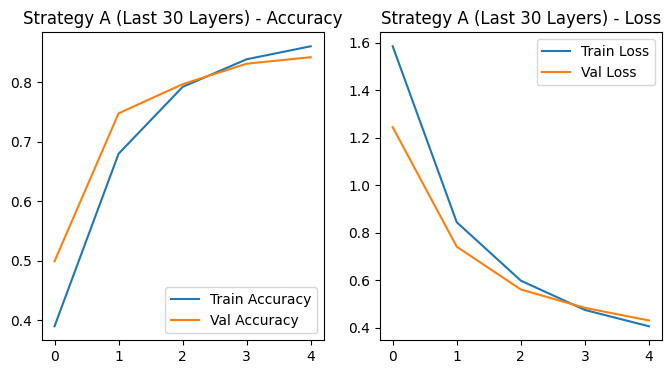

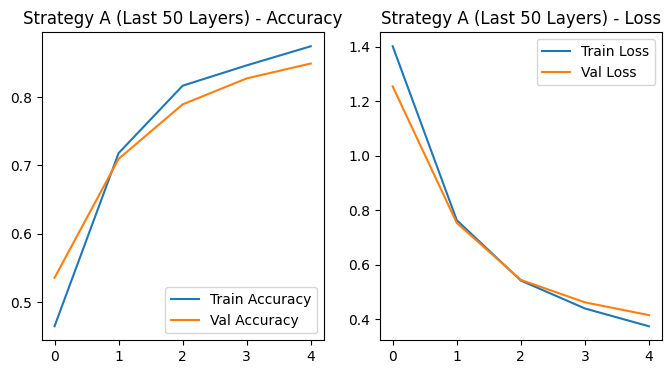

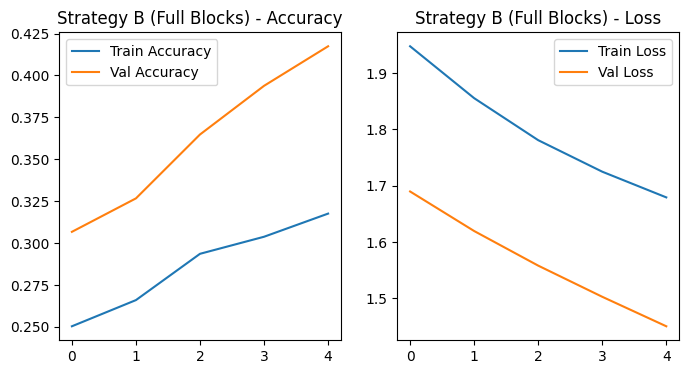

In [ ]:
plot_history(history_A_30, "Strategy A (Last 30 Layers)")
plot_history(history_A_50, "Strategy A (Last 50 Layers)")
plot_history(history_B, "Strategy B (Full Blocks)")


--- Evaluating model on test set ---
Test accuracy: 85.29%
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


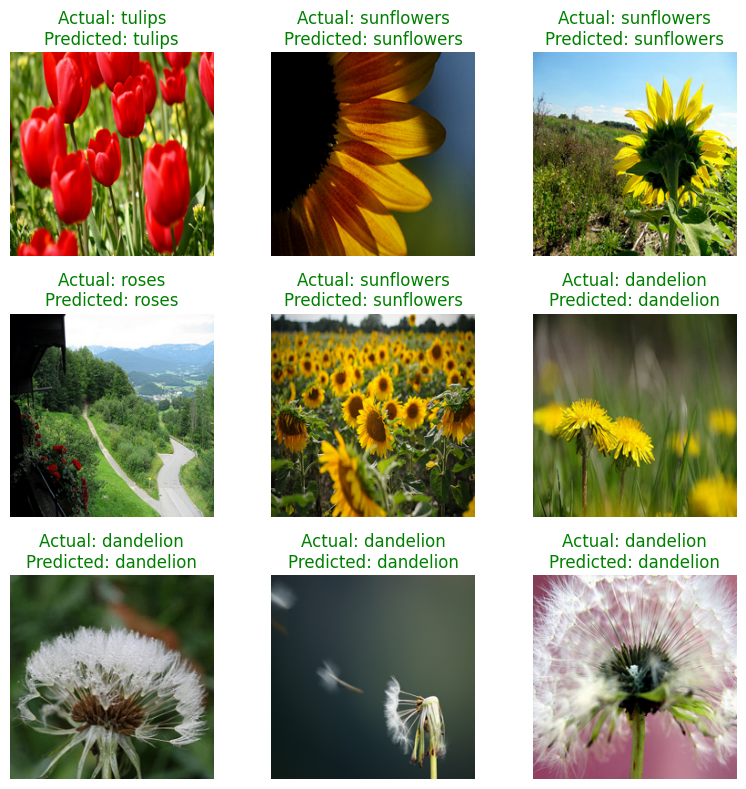

(0.39144468307495117, 0.8528610467910767)

In [ ]:
evaluate_model(base_model_A_30, test_images, test_labels, class_names)


--- Evaluating model on test set ---
Test accuracy: 88.83%
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


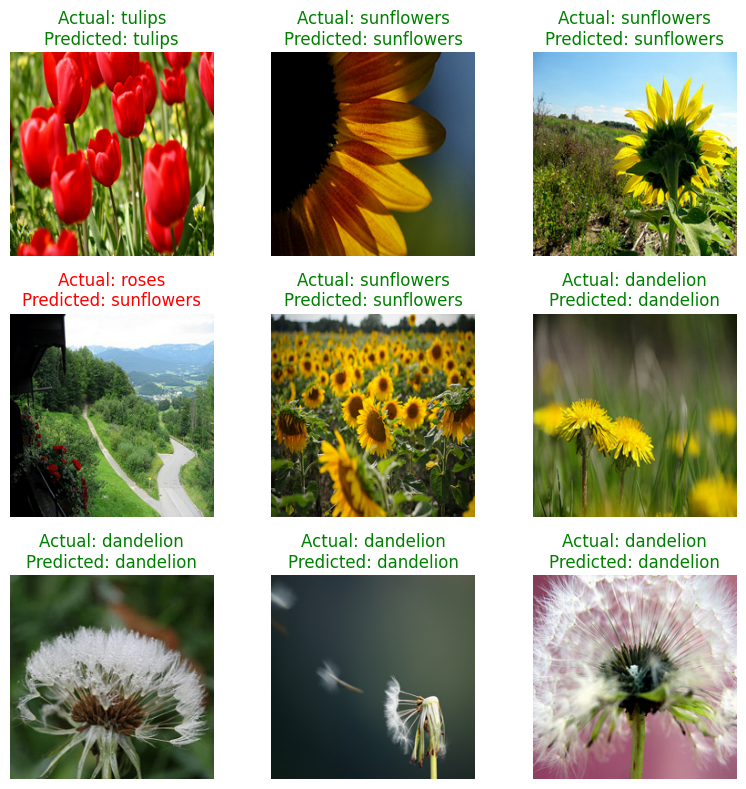

(0.3868533670902252, 0.888283371925354)

In [ ]:
evaluate_model(base_model_A_50, test_images, test_labels, class_names)


--- Evaluating model on test set ---
Test accuracy: 35.97%
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


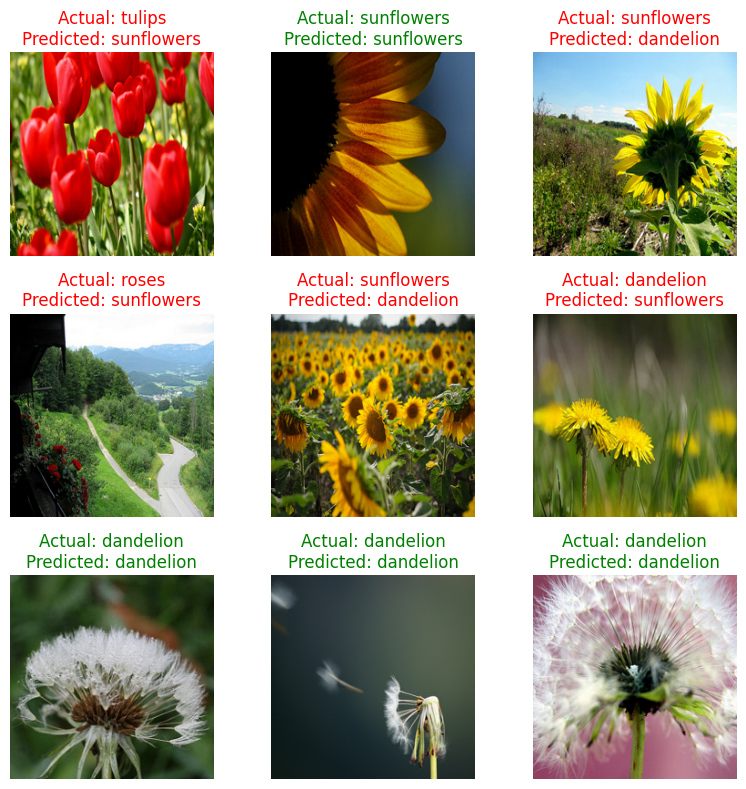

(1.5063865184783936, 0.35967302322387695)

In [ ]:
evaluate_model(base_model_B, test_images, test_labels, class_names)